Getting started with Kaggle can be an intimidating prospect! So I wrote this kernel to help you get started quickly. You can fork it, plug in a dataset you wanna you’ve been itching to explore and be doing analysis in 5 mins.

If you like this kernel, please give it an upvote. Thank you!

Happy Kagglin!

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import json
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# models
from xgboost import XGBRegressor
import warnings
# Ignore useless warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Avoid runtime error messages
pd.set_option('display.float_format', lambda x:'%f'%x)

# make notebook's output stable across runs
np.random.seed(42)

<Figure size 1600x800 with 0 Axes>

In [2]:
# Read CSVs
fetch_from = '../input/train.csv'
train = pd.read_csv(fetch_from)

fetch_from = '../input/test.csv'
test = pd.read_csv(fetch_from)

# Overview of training and test datasets

In [3]:
# How many datapoints in the training set?
train.shape

(1460, 81)

In [4]:
# How many datapoints in the test set?
test.shape

(1459, 80)

In [5]:
# Look at sample datapoints in the training set
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70.000000,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,6,8,1963,2003,Hip,CompShg,HdBoard,HdBoard,None,0.000000,TA,TA,CBlock,TA,TA,No,GLQ,663,Unf,0,396,1059,GasA,...,Y,SBrkr,1068,0,0,1068,0,1,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1963.000000,RFn,1,264,TA,TA,Y,192,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1105,1106,60,RL,98.000000,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1994,1995,Gable,CompShg,HdBoard,HdBoard,BrkFace,362.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1032,Unf,0,431,1463,GasA,...,Y,SBrkr,1500,1122,0,2622,1,0,2,1,3,1,Gd,9,Typ,2,TA,Attchd,1994.000000,RFn,2,712,TA,TA,Y,186,32,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
413,414,30,RM,56.000000,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,6,1927,1950,Gable,CompShg,WdShing,Wd Shng,None,0.000000,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1008,1008,GasA,...,Y,FuseA,1028,0,0,1028,0,0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1927.000000,Unf,2,360,TA,TA,Y,0,0,130,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000
522,523,50,RM,50.000000,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Feedr,Norm,1Fam,1.5Fin,6,7,1947,1950,Gable,CompShg,CemntBd,CmentBd,None,0.000000,TA,Gd,CBlock,TA,TA,No,ALQ,399,Unf,0,605,1004,GasA,...,Y,SBrkr,1004,660,0,1664,0,0,2,0,3,1,TA,7,Typ,2,Gd,Detchd,1950.000000,Unf,2,420,TA,TA,Y,0,24,36,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
1036,1037,20,RL,89.000000,12898,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2007,2008,Hip,CompShg,VinylSd,VinylSd,Stone,70.000000,Gd,TA,PConc,Ex,TA,Gd,GLQ,1022,Unf,0,598,1620,GasA,...,Y,SBrkr,1620,0,0,1620,1,0,2,0,2,1,Ex,6,Typ,1,Ex,Attchd,2008.000000,Fin,3,912,TA,TA,Y,228,0,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,315500


In [6]:
# Look at sample datapoints in the test set
test.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1084,2545,50,RL,74.000000,16287,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,5,6,1925,1950,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,Gd,CBlock,TA,TA,No,ALQ,130.000000,BLQ,105.000000,666.000000,901.000000,GasA,TA,Y,SBrkr,901,450,0,1351,1.000000,0.000000,1,0,3,1,TA,7,Typ,1,Gd,Detchd,1975.000000,Unf,2.000000,576.000000,TA,TA,N,0,0,43,0,100,0,NaN,NaN,NaN,0,7,2007,WD,Normal
1416,2877,70,RL,69.000000,4899,Pave,NaN,Reg,HLS,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,2Story,6,8,1920,1950,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,PConc,TA,TA,No,BLQ,305.000000,Unf,0.000000,450.000000,755.000000,GasA,Ex,Y,SBrkr,755,755,0,1510,0.000000,0.000000,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.000000,Unf,1.000000,216.000000,TA,TA,Y,0,0,164,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
682,2143,85,RL,nan,7400,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,SFoyer,5,5,1984,1984,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,Av,LwQ,104.000000,ALQ,956.000000,0.000000,1060.000000,GasA,TA,Y,SBrkr,1126,0,0,1126,1.000000,0.000000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1984.000000,Unf,2.000000,506.000000,TA,TA,Y,178,0,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal
1216,2677,60,RL,nan,8658,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,ALQ,732.000000,Unf,0.000000,250.000000,982.000000,GasA,Ex,Y,SBrkr,1008,881,0,1889,0.000000,0.000000,2,1,3,1,TA,9,Typ,1,TA,Attchd,2000.000000,Fin,2.000000,431.000000,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
1307,2768,90,RL,75.000000,8512,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,5,1960,1960,Hip,CompShg,BrkFace,BrkFace,None,0.000000,TA,TA,CBlock,TA,Fa,No,Unf,0.000000,Unf,0.000000,1556.000000,1556.000000,GasA,TA,Y,SBrkr,1556,0,0,1556,0.000000,0.000000,2,0,4,2,TA,8,Typ,0,NaN,NaN,nan,NaN,0.000000,0.000000,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Normal


## What's missing?

In [7]:
# How many missing values does the dataset have?
train.isnull().sum().sum()

6965

In [8]:
# Which columns have the most missing values?
def missing_data(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/train.isnull().count()*100)
    missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        types.append(dtype)
    missing_values['Types'] = types
    missing_values.sort_values('Total',ascending=False,inplace=True)
    return(np.transpose(missing_values))
missing_data(train)

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,MasVnrArea,MasVnrType,Electrical,Id,Functional,Fireplaces,KitchenQual,KitchenAbvGr,BedroomAbvGr,HalfBath,FullBath,BsmtHalfBath,TotRmsAbvGrd,GarageCars,GrLivArea,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,...,YrSold,SaleType,SaleCondition,BsmtFullBath,HeatingQC,LowQualFinSF,LandSlope,OverallQual,HouseStyle,BldgType,Condition2,Condition1,Neighborhood,LotConfig,YearBuilt,Utilities,LandContour,LotShape,Street,LotArea,MSZoning,OverallCond,YearRemodAdd,2ndFlrSF,BsmtFinSF2,1stFlrSF,CentralAir,MSSubClass,Heating,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,RoofStyle,Foundation,ExterCond,ExterQual,Exterior2nd,Exterior1st,RoofMatl,SalePrice
Total,1453,1406,1369,1179,690,259,81,81,81,81,81,38,38,37,37,37,8,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,99.520548,96.301370,93.767123,80.753425,47.260274,17.739726,5.547945,5.547945,5.547945,5.547945,5.547945,2.602740,2.602740,2.534247,2.534247,2.534247,0.547945,0.547945,0.068493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Types,object,object,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,float64,object,object,int64,object,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,...,int64,object,object,int64,object,int64,object,int64,object,object,object,object,object,object,int64,object,object,object,object,int64,object,int64,int64,int64,int64,int64,object,int64,object,int64,int64,int64,object,object,object,object,object,object,object,int64


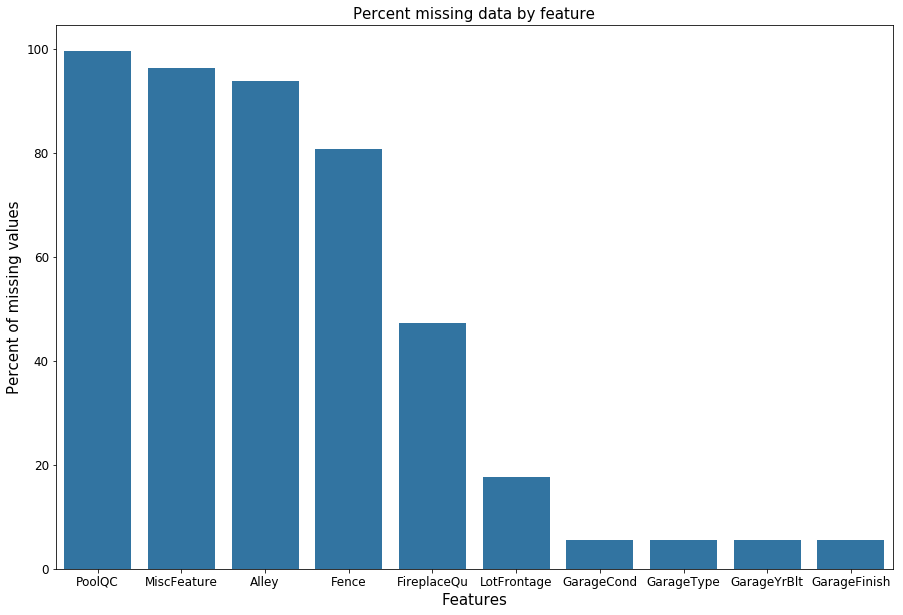

In [9]:
# Let's plot these missing values(%) vs column_names
missing_values_count = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
plt.figure(figsize=(15,10))
base_color = sns.color_palette()[0]
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
sns.barplot(missing_values_count[:10].index.values, missing_values_count[:10], color = base_color)

# Time to deep dive into the data!

## Numerical Features

In [10]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.581220,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.647420,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.000000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


The training and test sets seem to have consistently distributed features. But just to make sure this is the case, let's plot features from both the training and test sets!

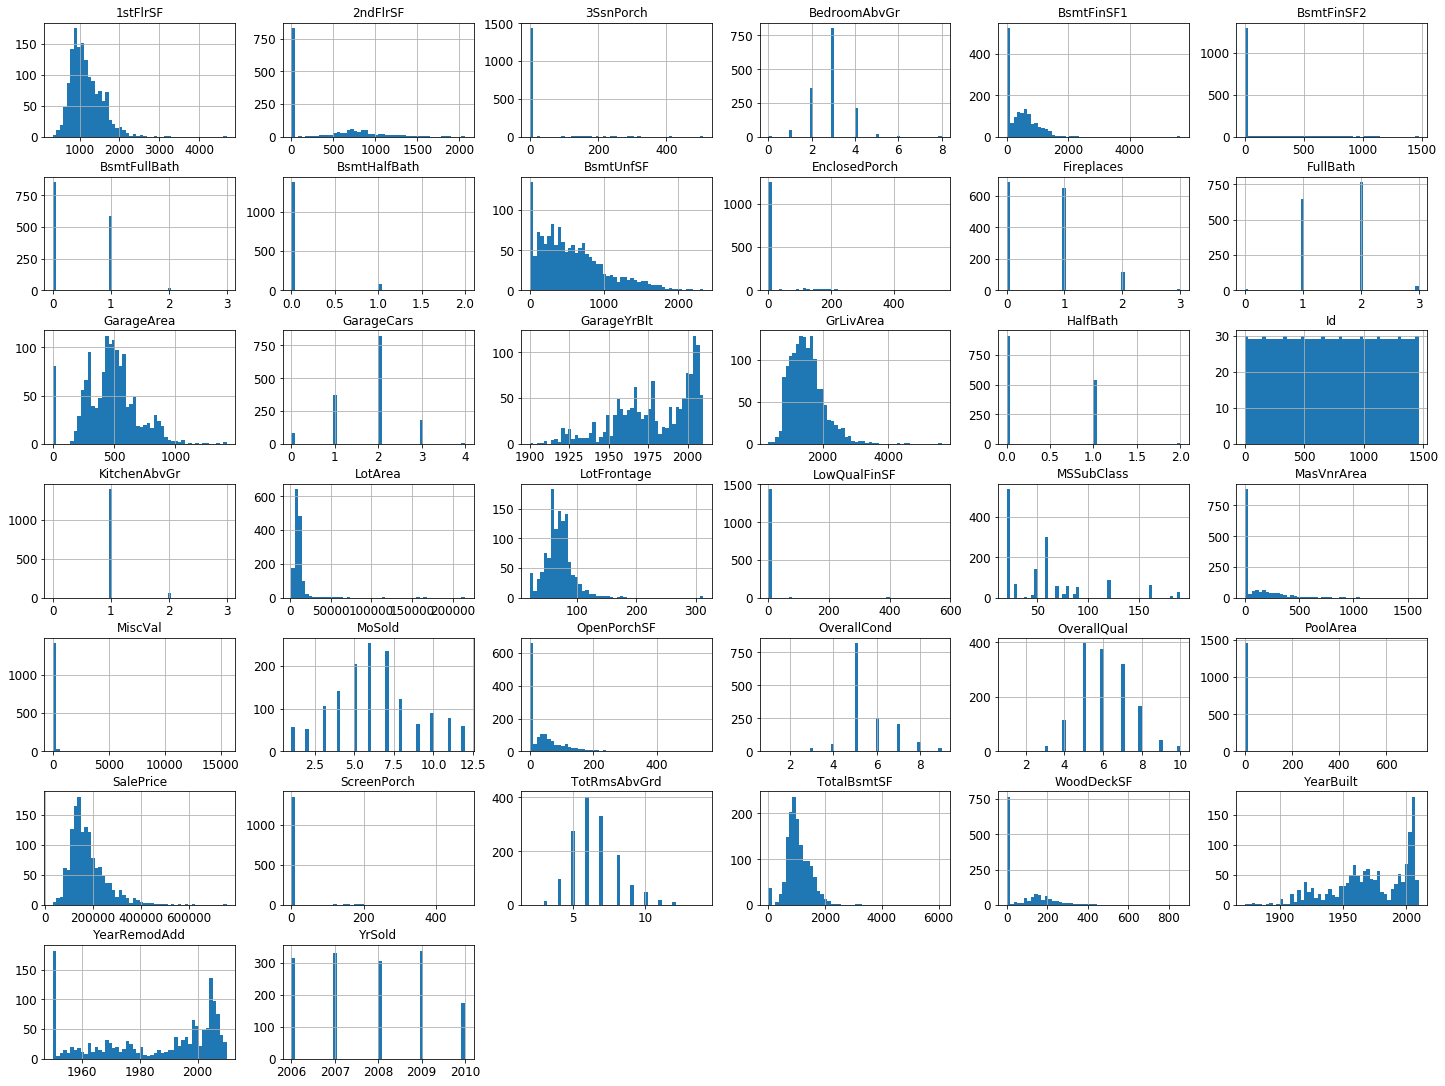

In [12]:
train.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

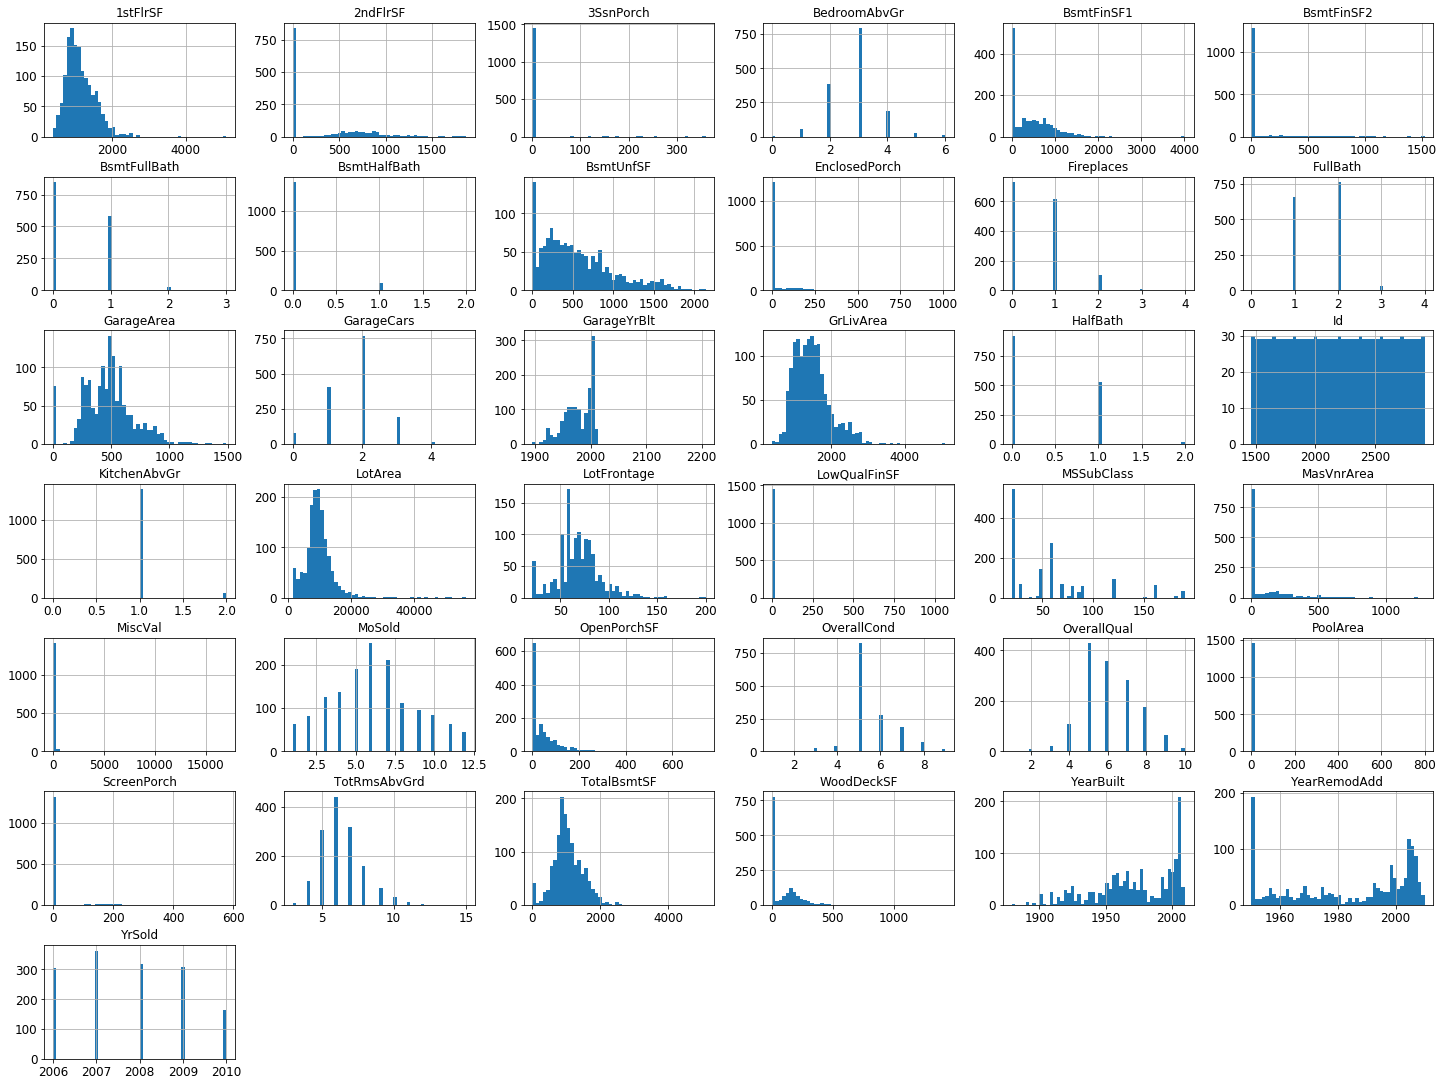

In [13]:
test.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

The distributions of features across the training and test data do indeed seem consistent. This is excellent!

## Categorical Features

In [14]:
train.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [15]:
test.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1459,107,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459,1459,1458,1458,1443,1459,1459,1459,1415,1414,1415,1417,1417,1459,1459,1459,1459,1458,1457,729,1383,1381,1381,1381,1459,3,290,51,1458,1459
unique,5,2,2,4,4,1,5,3,25,9,5,5,7,6,4,13,15,4,4,5,6,4,4,4,6,6,4,5,2,4,4,7,5,6,3,4,5,3,2,4,3,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1114,1453,70,934,1311,1457,1081,1396,218,1251,1444,1205,745,1169,1442,510,510,878,892,1256,661,634,1295,951,431,1237,1446,752,1358,1337,757,1357,364,853,625,1293,1328,1301,2,172,46,1258,1204


Before we mvoe forward, let's make a copy of the training set!

In [16]:
train_eda = train.copy()
label_col = 'SalePrice'

## Closer look at a few of these variables

In [17]:
col_name = 'HouseStyle'
freq_table = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="count")      # Name the count column
freq_table_per = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="percentage", normalize=True)
freq_table['percentage'] = freq_table_per['percentage']
freq_table.sort_values(by='count', ascending=False)

col_0,count,percentage
HouseStyle,,
1Story,726,0.497260
2Story,445,0.304795
1.5Fin,154,0.105479
SLvl,65,0.044521
SFoyer,37,0.025342
1.5Unf,14,0.009589
2.5Unf,11,0.007534
2.5Fin,8,0.005479


(-0.9450000000000001, 9.945, 0.0, 10.89)

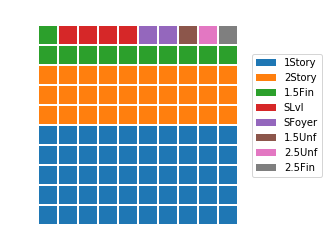

In [18]:
# First, we need to create a function to decide how many blocks to allocate to each category
def percentage_blocks(df, var):
    """
    Take as input a dataframe and variable, and return a Pandas series with
    approximate percentage values for filling out a waffle plot.
    """
    # compute base quotas
    percentages = 100 * df[var].value_counts() / df.shape[0]
    counts = np.floor(percentages).astype(int) # integer part = minimum quota
    decimal = (percentages - counts).sort_values(ascending = False)
    # add in additional counts to reach 100
    rem = 100 - counts.sum()
    for cat in decimal.index[:rem]:
        counts[cat] += 1
    return counts

# Second, plot those counts as boxes in the waffle plot form
waffle_counts = percentage_blocks(train_eda, col_name)
prev_count = 0
# for each category,
for cat in range(waffle_counts.shape[0]):
    # get the block indices
    blocks = np.arange(prev_count, prev_count + waffle_counts[cat])
    # and put a block at each index's location
    x = blocks % 10 # use mod operation to get ones digit
    y = blocks // 10 # use floor division to get tens digit
    plt.bar(x = x, height = 0.9, width = 0.9, bottom = y)
    prev_count += waffle_counts[cat]

# Third, we need to do involve aesthetic cleaning to polish it up for interpretability. We can take away the plot border and ticks, since they're arbitrary, but we should change the limits so that the boxes are square. We should also add a legend so that the mapping from colors to category levels is clear.
# aesthetic wrangling
plt.legend(waffle_counts.index, bbox_to_anchor = (1, 0.5), loc = 6)
plt.axis('off')
plt.axis('square')

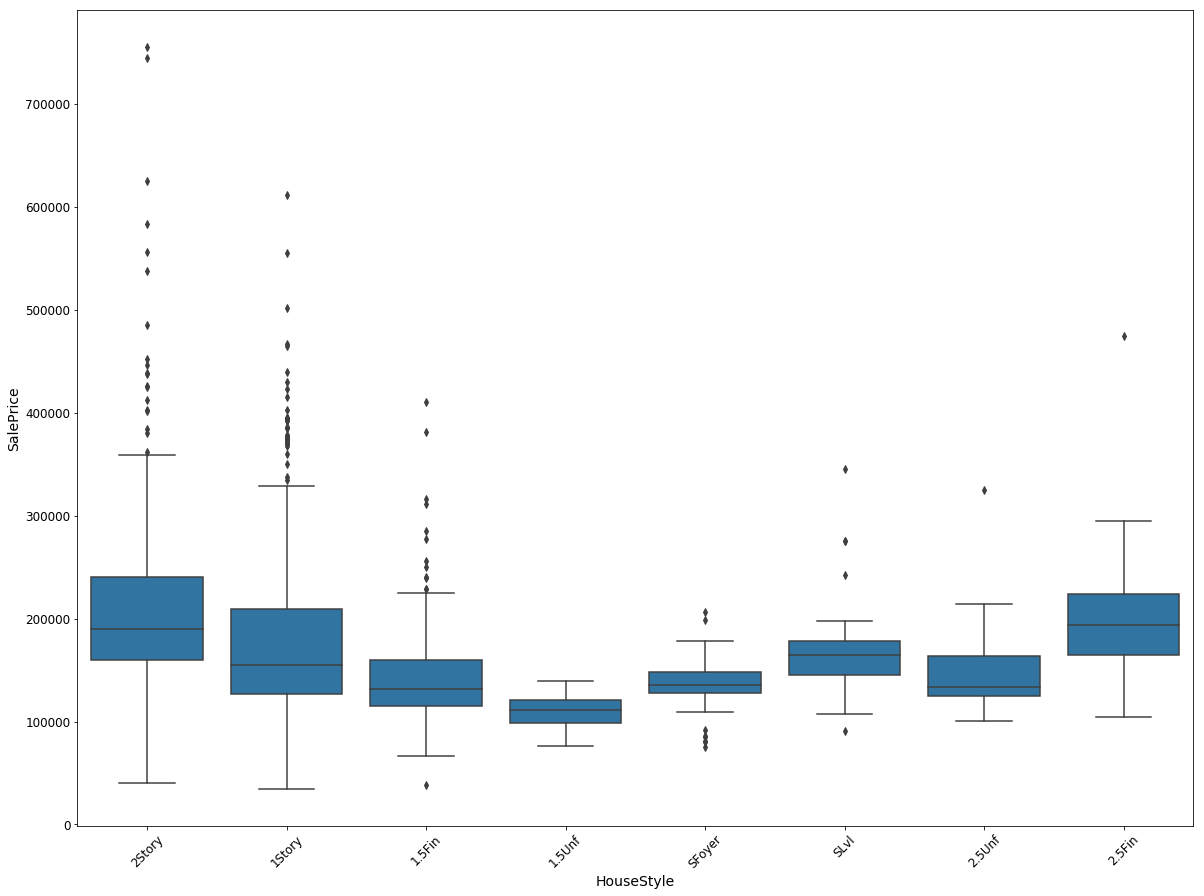

In [19]:
# Area depicts the distribution of points. > width = > the number of points
base_color = sns.color_palette()[0]
plt.figure(figsize=(20,15))
plt.xticks(rotation=45)
sns.boxplot(data = train_eda, x = 'HouseStyle', y = 'SalePrice', color = base_color);

In [20]:
col_name = 'HouseStyle'
freq_table = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="count")      # Name the count column
freq_table_per = pd.crosstab(index=train_eda[col_name],  # Make a crosstab
                              columns="percentage", normalize=True)
freq_table['percentage'] = freq_table_per['percentage']
freq_table.sort_values(by='count', ascending=False)

col_0,count,percentage
HouseStyle,,
1Story,726,0.497260
2Story,445,0.304795
1.5Fin,154,0.105479
SLvl,65,0.044521
SFoyer,37,0.025342
1.5Unf,14,0.009589
2.5Unf,11,0.007534
2.5Fin,8,0.005479


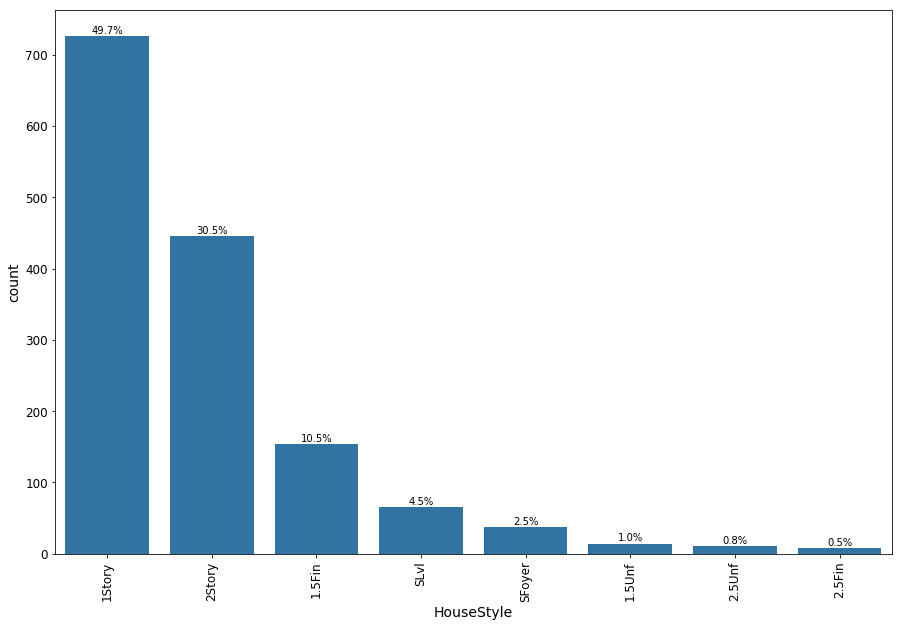

In [21]:
# Relative frequency variation - Plotting absolute counts on axis and porportions on the bars
# Barchart sorted by frequency
base_color = sns.color_palette()[0]
cat_order = train_eda[col_name].value_counts().index
plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
sns.countplot(data = train_eda, x = col_name, order = cat_order, color = base_color);

# add annotations
n_points = train_eda.shape[0]
cat_counts = train_eda[col_name].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count+4, pct_string, ha = 'center', color = 'black')

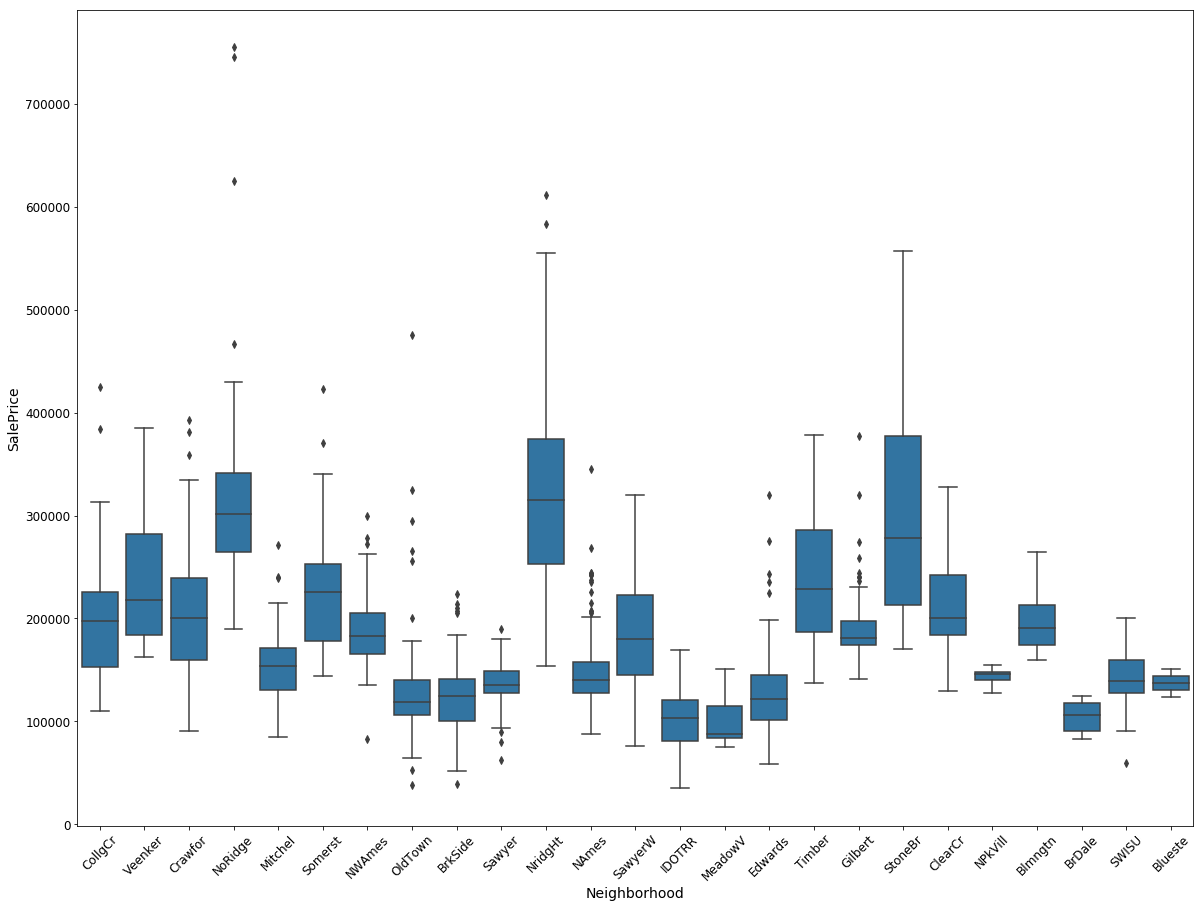

In [22]:
# Area depicts the distribution of points. > width = > the number of points
base_color = sns.color_palette()[0]
plt.figure(figsize=(20,15))
plt.xticks(rotation=45)
sns.boxplot(data = train_eda, x = 'Neighborhood', y = 'SalePrice', color = base_color);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


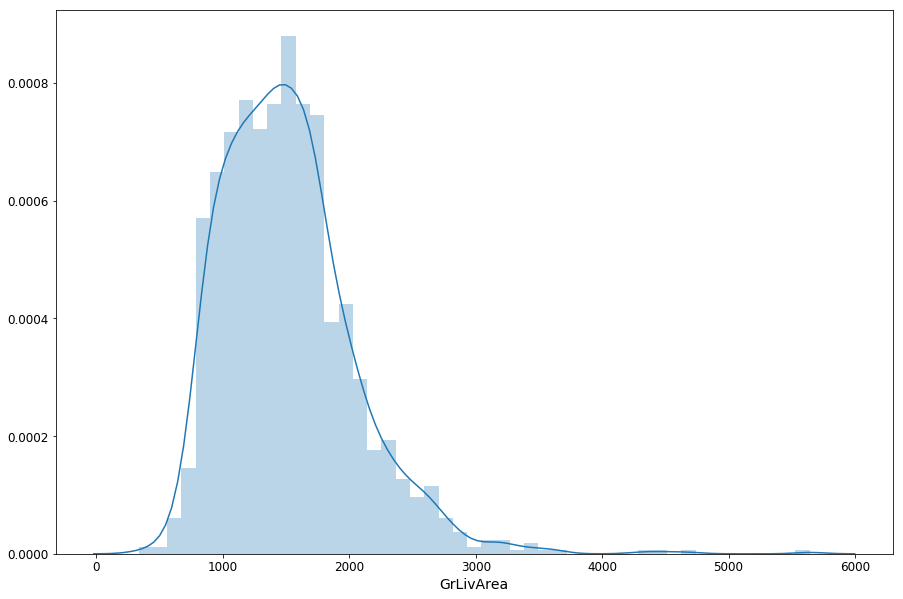

In [23]:
col_name = 'GrLivArea'
hist_kws={"alpha": 0.3}
plt.figure(figsize=(15,10))
# Trim long-tail/other values
# plt.xlim(0, 1200)
sns.distplot(train_eda[col_name], hist_kws=hist_kws);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


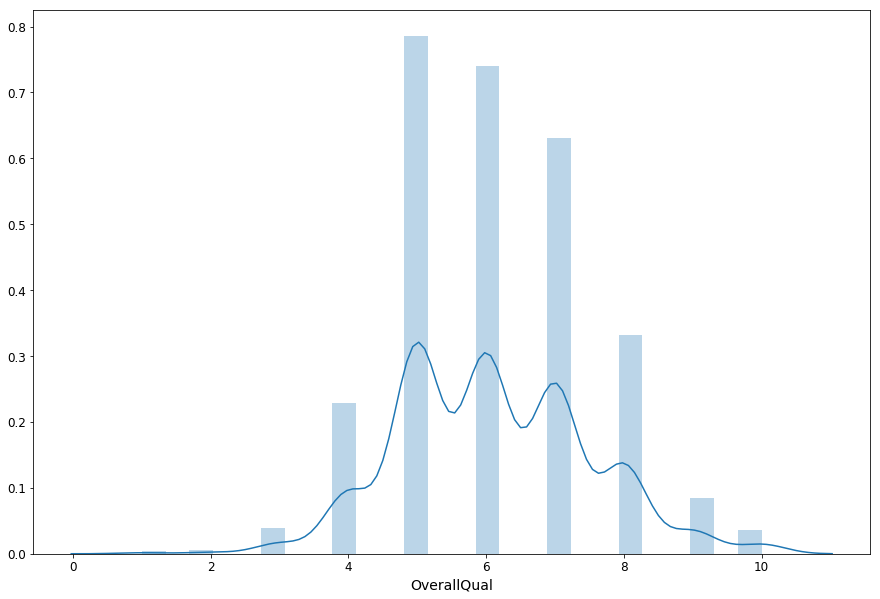

In [24]:
col_name = 'OverallQual'
hist_kws={"alpha": 0.3}
plt.figure(figsize=(15,10))
# Trim long-tail/other values
# plt.xlim(0, 1200)
sns.distplot(train_eda[col_name], hist_kws=hist_kws);

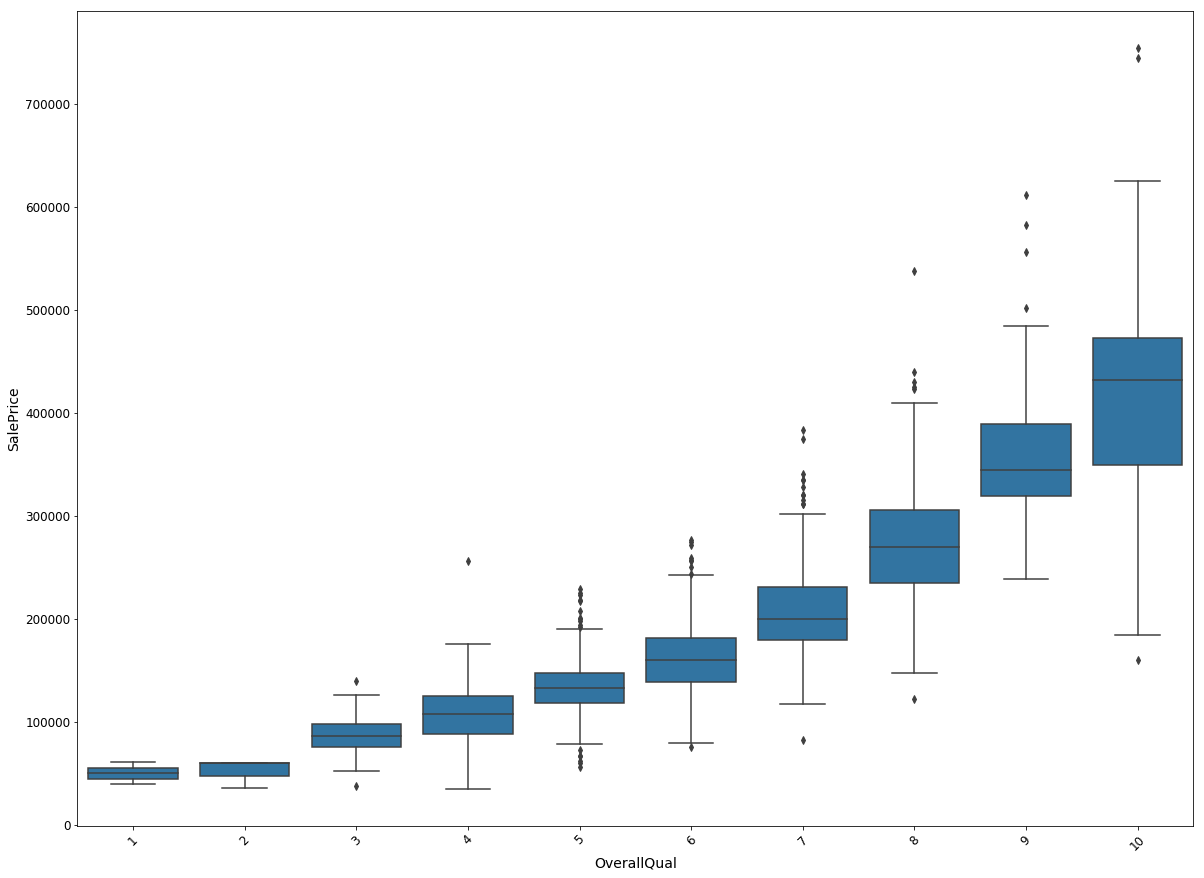

In [25]:
col_name = 'OverallQual'
base_color = sns.color_palette()[0]
plt.figure(figsize=(20,15))
plt.xticks(rotation=45)
sns.boxplot(data = train_eda, x = col_name, y = 'SalePrice', color = base_color)

Alright, we have some understanding of the features in our training set! Let's see how useful they might be in predicting our SalePrice!

# What're the most correlated features?

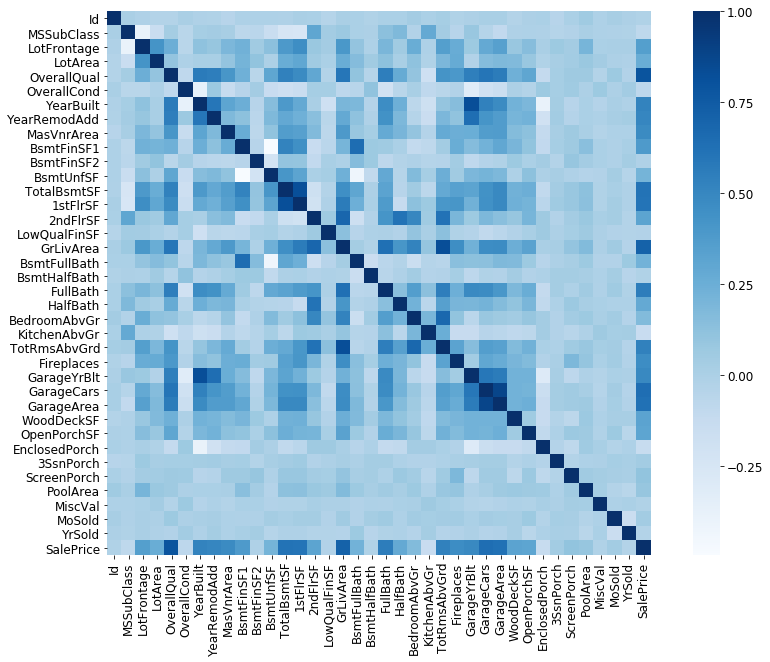

In [26]:
# Which features are the most correlated to our target variable, SalePrice?
corr_matrix = train_eda.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix, vmax=1.0, square=True, cmap="Blues")

In [27]:
# Get the top 10 most correlated features
corr_matrix = train_eda.corr()
corr_matrix[label_col].sort_values(ascending=False)[:10]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
Name: SalePrice, dtype: float64

Note: .corr() only captures linear relationships, so it's not the most reliable way to detect correlations. So let's plot a few of these features on a scatterplot matrix!

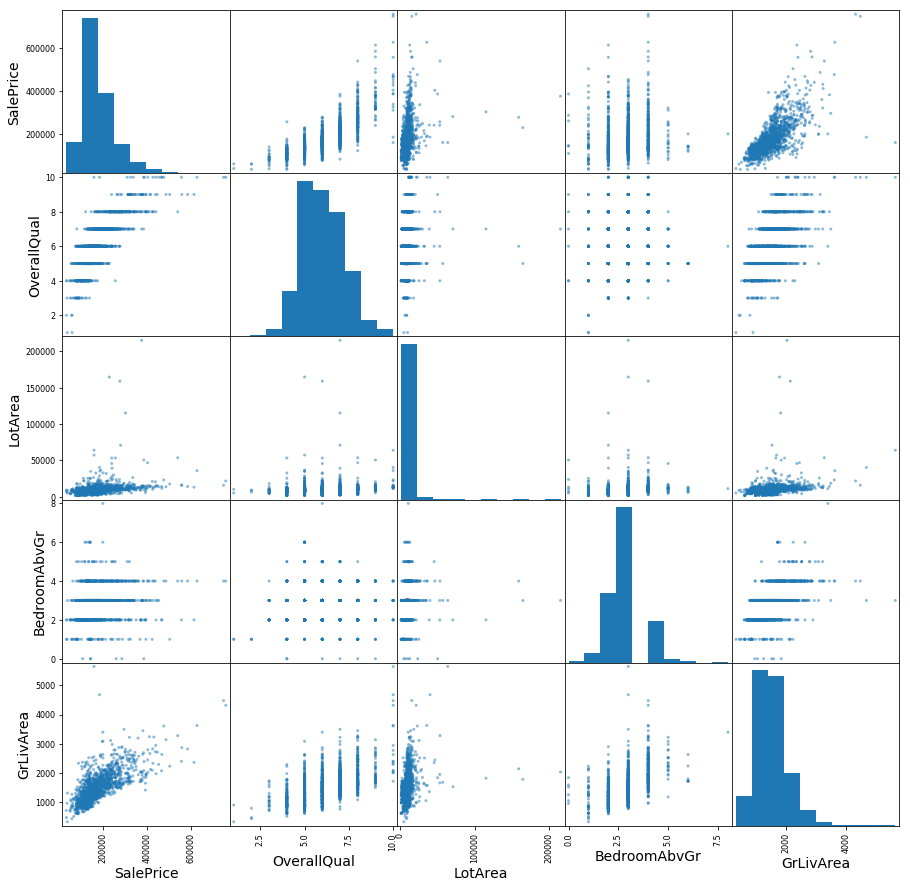

In [28]:
from pandas.plotting import scatter_matrix

attributes = [label_col, "OverallQual", "LotArea", "BedroomAbvGr", "GrLivArea"]
scatter_matrix(train_eda[attributes], figsize=(15, 15));

How good a predictor is GarageArea for SalePrice?

[0, 400000, 0, 1200]

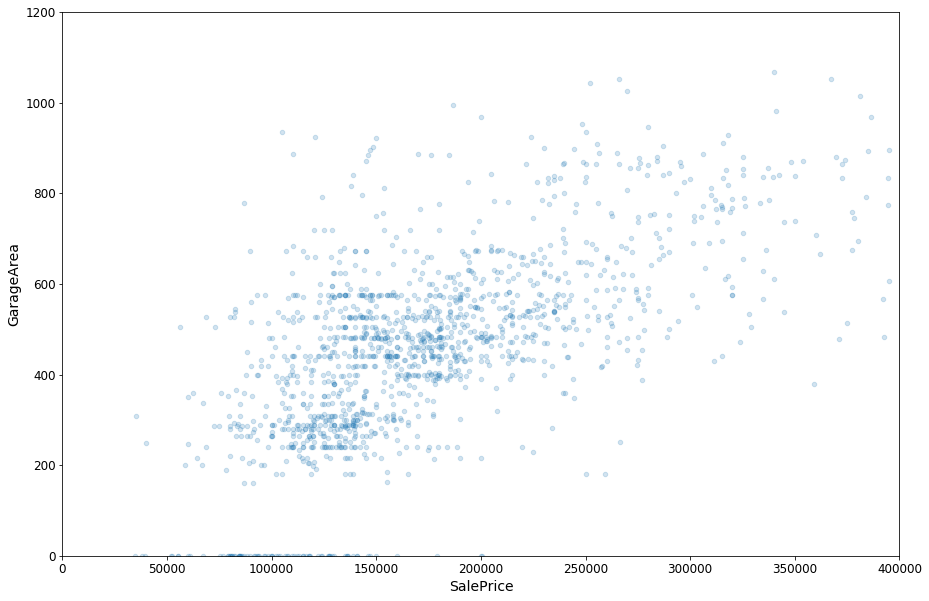

In [29]:
col_name = 'GarageArea'
train_eda.plot(kind="scatter", x=label_col, y=col_name, alpha=0.2, figsize=(15,10))
# changing axis labels to only show part of the graph
plt.axis([0, 400000, 0, 1200])

Let's add some more context to our GarageArea vs SalePrice plot! Let's color it by the year sold (YrSold) and change the size accoding to the number of bedrooms above ground (BedroomAbvGr).

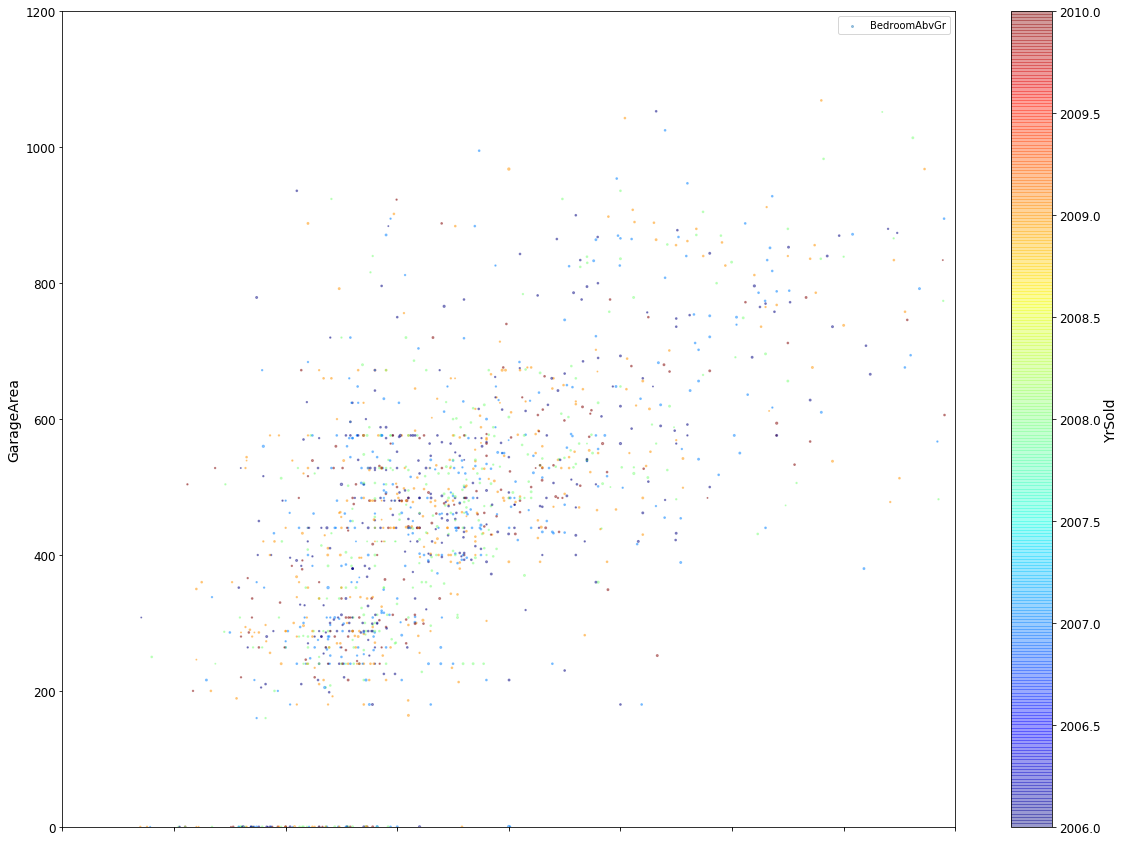

In [30]:
train_eda.plot(kind="scatter", x=label_col, y="GarageArea", alpha=0.4,
             s=train_eda["BedroomAbvGr"], label="BedroomAbvGr", figsize=(20,15),
             c="YrSold", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.axis([0, 400000, 0, 1200])
plt.legend();

# Feature Engineering and Prep

Before we go forward, let's make a copy of the training set!

In [31]:
train_fe = train.copy()
test_fe = test.copy()

## Remove outliers

In [32]:
train_fe = train_fe[train_fe.GrLivArea < 4300]
train_fe.reset_index(drop=True, inplace=True)

train_fe["SalePrice"] = np.log1p(train_fe["SalePrice"])
y = train_fe.SalePrice.reset_index(drop=True)
train_features = train_fe.drop(['SalePrice'], axis=1)
test_features = test.copy()

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

(2915, 80)


## Fill missing values

In [33]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features["PoolQC"] = features["PoolQC"].fillna("None")
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
features.update(features[objects].fillna('None'))

## Reconcile feature types

In [34]:
# Convert categorical variables stored as numbers to strings
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Other Feature Engineering

In [35]:
# Remove Id
train_ID = train_fe['Id']
test_ID = test_fe['Id']

train_fe.drop(['Id'], axis=1, inplace=True)
test_fe.drop(['Id'], axis=1, inplace=True)

# Create new features
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

# Fix skewed features
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
final_features = pd.get_dummies(features).reset_index(drop=True)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [36]:
X.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,18.411543,13.814182,7,3.991272,2003,2003,19.577285,145.420491,0.000000,29.982199,428.729642,6.023669,1131.528584,0.000000,9.174839,0.993331,0.000000,2,1.068320,3,0.750953,2.265894,0.000000,2003.000000,2.000000,548.000000,0.000000,12.070774,0.000000,0.000000,0.000000,0.000000,0.000000,4006,101.405125,45.778434,3.500000,18.718779,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20.996299,14.098354,6,5.999564,1976,1976,0.000000,183.461369,0.000000,44.120317,603.263099,6.328750,0.000000,0.000000,8.723722,0.000000,0.709765,2,0.000000,3,0.750953,1.999643,0.903265,1976.000000,2.000000,460.000000,56.087424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3952,100.550004,44.438126,2.500000,51.564335,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,18.946324,14.456065,7,3.991272,2001,2002,17.894858,111.370406,0.000000,56.875261,456.812989,6.080637,1148.202357,0.000000,9.240029,0.993331,0.000000,2,1.068320,3,0.750953,1.999643,0.903265,2001.000000,2.000000,608.000000,0.000000,9.894089,0.000000,0.000000,0.000000,0.000000,0.000000,4003,104.206476,44.686622,3.500000,14.642535,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,17.497575,14.086662,7,3.991272,1915,1970,0.000000,62.233105,0.000000,64.783549,384.328657,6.115019,995.800058,0.000000,9.180957,0.993331,0.000000,1,0.000000,3,0.750953,2.140878,0.903265,1998.000000,3.000000,642.000000,0.000000,8.960139,16.029411,0.000000,0.000000,0.000000,0.000000,3885,99.502089,41.931801,2.000000,52.536533,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,21.651481,15.000187,8,3.991272,2000,2000,25.618139,137.842332,0.000000,61.142946,553.779273,6.252659,1409.402974,0.000000,9.553356,0.993331,0.000000,2,1.068320,4,0.750953,2.378073,0.903265,2000.000000,3.000000,836.000000,42.179739,14.259257,0.000000,0.000000,0.000000,0.000000,0.000000,4000,116.127161,48.860188,3.500000,49.138573,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1455
Columns: 332 entries, Id to SaleCondition_Partial
dtypes: float64(33), int64(11), uint8(288)
memory usage: 918.2 KB


In [38]:
features_train = train.copy()
features_train.dropna(axis=0, subset=['SalePrice'], inplace=True)
label = features_train.SalePrice
features_train = features_train.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(features_train.as_matrix(), label.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Train a basic XGBoost to serve as a benchmark

Defining a basic XGBoost model.

In [39]:
xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42);

xgb.fit(train_X, train_y)
predictions = xgb.predict(test_X)

## Defining our scoring metrics

In [40]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def mae(y, y_pred):
    return mean_absolute_error(predictions, test_y)

In [41]:
print('MAE score on train data:')
print(mae(predictions, test_y))

MAE score on train data:
16565.69885488014


# Next steps:
- Try a bunch of other models, using GridSearch and CrossValidation
- A combo of XGRegressor, CatBoostRegressor, RandomForestRegressor, SVR and RidgeRegression worked best for me